In [ ]:
# Check Colab Pro / Local instance specs
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

In [105]:
import os
import re
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
%matplotlib inline

# Setting up Google Drive access if not running locally

In [ ]:
# Mount Google Drive. Confirm access permissions to permit this notebook to access your Google Drive files
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# drive.mount("/content/drive", force_remount=True) # Run if the Google drive needs to be remounted

In [ ]:
# change proj_gdrive_dir string to personal gdrive project code path

proj_dir = '/content/drive/MyDrive/' + 'datasci-210/datasci-210-project/fraud-detect/'
proj_dir_data_raw = proj_dir + 'data/raw/' # Assign data folder under project code path. Create separately in Gdrive
proj_dir_data_proc = proj_dir + 'data/processed/'
!ls $proj_dir
print('-----------------------------------------------------------------------')
!ls $proj_dir_data_raw
print('-----------------------------------------------------------------------')
!ls $proj_dir_data_proc

In [ ]:
# Run after completing Notebook run to gracefully disconnect Gdrive
# drive.flush_and_unmount()

# Loading locally

In [2]:
%pwd

'/home/jovyan/work/fraud-detect/notebooks'

In [3]:
proj_dir = '/home/jovyan/work/fraud-detect/'
proj_dir_data_raw = proj_dir + 'data/raw/'
proj_dir_data_proc = proj_dir + 'data/processed/'

# Load Raw Data

In [ ]:
# Load SBA PPP files into data frame from individual files and export to processed folder
ppp_files_li = [filename for filename in os.listdir(proj_dir_data_raw) if filename.startswith('public_')]

In [ ]:
dtype_dict = {
    'LoanNumber':'str',
    'DateApproved':'str',
    'SBAOfficeCode':'str',
    'ProcessingMethod':'str',
    'BorrowerName':'str',
    'BorrowerAddress':'str',
    'BorrowerCity':'str',
    'BorrowerState':'str',
    'BorrowerZip':'str',
    'LoanStatusDate':'str',
    'LoanStatus':'str',
    # 'Term':'Int',
    # 'SBAGuarantyPercentage':'int',
    'InitialApprovalAmount':'float',
    'CurrentApprovalAmount':'float',
    'UndisbursedAmount':'float',
    'FranchiseName':'str',
    'ServicingLenderLocationID':'str',
    'ServicingLenderName':'str',
    'ServicingLenderAddress':'str',
    'ServicingLenderCity':'str',
    'ServicingLenderState':'str',
    'ServicingLenderZip':'str',
    'RuralUrbanIndicator':'str',
    'HubzoneIndicator':'str',
    'LMIIndicator':'str',
    'BusinessAgeDescription':'str',
    'ProjectCity':'str',
    'ProjectCountyName':'str',
    'ProjectState':'str',
    'ProjectZip':'str',
    'CD':'str',
    # 'JobsReported':'int',
    'NAICSCode':'str',
    'Race':'str',
    'Ethnicity':'str',
    'UTILITIES_PROCEED':'float',
    'PAYROLL_PROCEED':'float',
    'MORTGAGE_INTEREST_PROCEED':'float',
    'RENT_PROCEED':'float',
    'REFINANCE_EIDL_PROCEED':'float',
    'HEALTH_CARE_PROCEED':'float',
    'DEBT_INTEREST_PROCEED':'float',
    'BusinessType':'str',
    'OriginatingLenderLocationID':'str',
    'OriginatingLender':'str',
    'OriginatingLenderCity':'str',
    'OriginatingLenderState':'str',
    'Gender':'str',
    'Veteran':'str',
    'NonProfit':'str',
    'ForgivenessAmount':'float',
    'ForgivenessDate':'str'
}

parse_dates = ['DateApproved', 'LoanStatusDate', 'ForgivenessDate']

In [ ]:
ppp_data = pd.concat([pd.read_csv(proj_dir_data_raw+filename, header=0, dtype=dtype_dict, parse_dates=parse_dates) for filename in ppp_files_li], ignore_index=True)

# filename = 'sba_ppp_combined.csv'
# df_ppp_data.to_csv(proj_dir_data_proc+filename, index=False)


In [ ]:
df_ppp_data = ppp_data.copy(deep=True)

In [ ]:
df_ppp_data.shape

In [ ]:
df_ppp_data = df_ppp_data.dropna(how='all')
df_ppp_data.shape

In [ ]:
cols = ['LoanNumber', 'BorrowerName', 'InitialApprovalAmount']
df_ppp_data = df_ppp_data.dropna(subset=cols)
df_ppp_data.shape

In [ ]:
# Modified from finance paper code
df_ppp_data['BorrowerName'] = df_ppp_data['BorrowerName']\
                                        .str.lower()\
                                        .str.replace('[^a-zA-Z0-9 ]', '')\
                                        .str.replace('(?<!\S)incorporated(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)llc(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)corporation(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)company(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)partnership(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)limited(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)inc(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)co(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)lc(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)pllc(?=\s|$)', ' ')\
                                        .str.replace('(?<!\S)llp(?=\s|$)', ' ')\
                                        .str.replace('\s\s+', ' ')\
                                        .str.strip()

In [ ]:
col_names = [
    'ProcessingMethod',
    'LoanStatus',
    'RuralUrbanIndicator',
    'HubzoneIndicator',
    'LMIIndicator',
    'Race',
    'Ethnicity',
    'BusinessType',
    'Gender',
    'Veteran',
    'NonProfit']

for col_name in col_names:
    df_ppp_data[col_name] = df_ppp_data[col_name].fillna('Unknown')

In [ ]:
col_names = [
    'ProcessingMethod',
    'LoanStatus',
    'RuralUrbanIndicator',
    'HubzoneIndicator',
    'LMIIndicator',
    'Race',
    'Ethnicity',
    'BusinessType',
    'Gender',
    'Veteran',
    'NonProfit']

for col_name in col_names:
    new_col = col_name + '_cat'
    # convert the column to categorical data type
    df_ppp_data[new_col] = pd.Categorical(df_ppp_data[col_name])
    # convert the 'fruit' column to int
    df_ppp_data[new_col] = df_ppp_data[new_col].cat.codes

In [ ]:
filename = 'sba_ppp_combined_cat.csv'
df_ppp_data.to_csv(proj_dir_data_proc+filename, index=False)

In [ ]:
# # Load SBA PPP Combined file
# filename = 'ppp-data-combined.csv'
# df_ppp_data = pd.read_csv(data_dir+'/'+filename, header=0)


# Load SBA PPP files into data frame from combined file
# df_ppp_data = pd.read_csv(data_dir+'/'+filename, header=0, ignore_index=True)

In [ ]:
# Export combined PPP dat to a .csv file
# filename = 'ppp-data-combined.csv'
# df_ppp_data.to_csv(data_dir+'/'+filename)

# Load Preprocessed PPP Data

In [4]:
dtype_dict = {
    'LoanNumber':'str',
    'DateApproved':'str',
    'SBAOfficeCode':'str',
    'ProcessingMethod':'str',
    'BorrowerName':'str',
    'BorrowerAddress':'str',
    'BorrowerCity':'str',
    'BorrowerState':'str',
    'BorrowerZip':'str',
    'LoanStatusDate':'str',
    'LoanStatus':'str',
    # 'Term':'Int',
    # 'SBAGuarantyPercentage':'int',
    'InitialApprovalAmount':'float',
    'CurrentApprovalAmount':'float',
    'UndisbursedAmount':'float',
    'FranchiseName':'str',
    'ServicingLenderLocationID':'str',
    'ServicingLenderName':'str',
    'ServicingLenderAddress':'str',
    'ServicingLenderCity':'str',
    'ServicingLenderState':'str',
    'ServicingLenderZip':'str',
    'RuralUrbanIndicator':'str',
    'HubzoneIndicator':'str',
    'LMIIndicator':'str',
    'BusinessAgeDescription':'str',
    'ProjectCity':'str',
    'ProjectCountyName':'str',
    'ProjectState':'str',
    'ProjectZip':'str',
    'CD':'str',
    # 'JobsReported':'int',
    'NAICSCode':'str',
    'Race':'str',
    'Ethnicity':'str',
    'UTILITIES_PROCEED':'float',
    'PAYROLL_PROCEED':'float',
    'MORTGAGE_INTEREST_PROCEED':'float',
    'RENT_PROCEED':'float',
    'REFINANCE_EIDL_PROCEED':'float',
    'HEALTH_CARE_PROCEED':'float',
    'DEBT_INTEREST_PROCEED':'float',
    'BusinessType':'str',
    'OriginatingLenderLocationID':'str',
    'OriginatingLender':'str',
    'OriginatingLenderCity':'str',
    'OriginatingLenderState':'str',
    'Gender':'str',
    'Veteran':'str',
    'NonProfit':'str',
    'ForgivenessAmount':'float',
    'ForgivenessDate':'str'
}

parse_dates = ['DateApproved', 'LoanStatusDate', 'ForgivenessDate']

In [5]:
filename = 'sba_ppp_combined_cat.csv'

df_ppp_data = pd.read_csv(proj_dir_data_proc+filename, header=0, dtype=dtype_dict, parse_dates=parse_dates)

In [6]:
df_ppp_data.columns

Index(['LoanNumber', 'DateApproved', 'SBAOfficeCode', 'ProcessingMethod',
       'BorrowerName', 'BorrowerAddress', 'BorrowerCity', 'BorrowerState',
       'BorrowerZip', 'LoanStatusDate', 'LoanStatus', 'Term',
       'SBAGuarantyPercentage', 'InitialApprovalAmount',
       'CurrentApprovalAmount', 'UndisbursedAmount', 'FranchiseName',
       'ServicingLenderLocationID', 'ServicingLenderName',
       'ServicingLenderAddress', 'ServicingLenderCity', 'ServicingLenderState',
       'ServicingLenderZip', 'RuralUrbanIndicator', 'HubzoneIndicator',
       'LMIIndicator', 'BusinessAgeDescription', 'ProjectCity',
       'ProjectCountyName', 'ProjectState', 'ProjectZip', 'CD', 'JobsReported',
       'NAICSCode', 'Race', 'Ethnicity', 'UTILITIES_PROCEED',
       'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED',
       'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED',
       'DEBT_INTEREST_PROCEED', 'BusinessType', 'OriginatingLenderLocationID',
       'OriginatingLender', 'Originatin

In [87]:
df_ppp_data.shape

(11765501, 64)

In [59]:
dtype_dict = {
    'LoanNumber':'str',
    'Fraud':'int'}

filename = 'labelled_unique.csv'

df_case_data = pd.read_csv(proj_dir_data_proc+filename, header=0, dtype=dtype_dict)
print(df_case_data.shape)
print(df_case_data.columns)

(626, 12)
Index(['Unnamed: 0', 'LoanNumber', 'BorrowerName', 'BorrowerNameProc', 'index',
       'State', 'Lookup', 'Fraud', 'Status', 'lookupproc', 'lookup_li',
       'case_index'],
      dtype='object')


In [70]:
df = pd.DataFrame()
df = df_ppp_data['LoanNumber'].copy(deep=True)

In [71]:
df.head()

0    2593527208
1    2741007306
2    3342508906
3    3379798208
4    3753429003
Name: LoanNumber, dtype: object

In [99]:
# df.loc[df_case_data.loc[df_case_data['Fraud'] == 1]['LoanNumber'].tolist(), 'fraud_case'] = 1
result = pd.merge(df_ppp_data, df_case_data[['LoanNumber','Fraud']], how="left", on='LoanNumber')

In [100]:
result['Fraud'] = result['Fraud'].fillna(0)

# Model

In [101]:
trunc_cols = ['LoanNumber', 'Term', 'InitialApprovalAmount',
       'CurrentApprovalAmount', 'UndisbursedAmount', 'JobsReported',
       'NAICSCode', 'UTILITIES_PROCEED',
       'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED',
       'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED',
       'DEBT_INTEREST_PROCEED', 'ForgivenessAmount', 'ProcessingMethod_cat', 'LoanStatus_cat',
       'RuralUrbanIndicator_cat', 'HubzoneIndicator_cat', 'LMIIndicator_cat',
       'Race_cat', 'Ethnicity_cat', 'BusinessType_cat', 'Gender_cat',
       'Veteran_cat', 'NonProfit_cat', 'Fraud']

In [102]:
df_ppp_trunc = result[trunc_cols].sample(frac=.10, replace=False, weights=None, random_state=None, axis=0, ignore_index=False)

In [103]:
df_ppp_trunc.shape

(1176550, 27)

In [104]:
df_ppp_trunc[df_ppp_trunc['Fraud']==1].count()

LoanNumber                   33
Term                         33
InitialApprovalAmount        33
CurrentApprovalAmount        33
UndisbursedAmount            33
JobsReported                 33
NAICSCode                    32
UTILITIES_PROCEED             9
PAYROLL_PROCEED              33
MORTGAGE_INTEREST_PROCEED     0
RENT_PROCEED                  2
REFINANCE_EIDL_PROCEED        0
HEALTH_CARE_PROCEED           0
DEBT_INTEREST_PROCEED         0
ForgivenessAmount            17
ProcessingMethod_cat         33
LoanStatus_cat               33
RuralUrbanIndicator_cat      33
HubzoneIndicator_cat         33
LMIIndicator_cat             33
Race_cat                     33
Ethnicity_cat                33
BusinessType_cat             33
Gender_cat                   33
Veteran_cat                  33
NonProfit_cat                33
Fraud                        33
dtype: int64

# Model Development

In [ ]:
df_ppp_trunc.isnull().sum()

In [109]:
df_ppp_trunc_clean = df_ppp_trunc

na_cols = ['NAICSCode']
df_ppp_trunc_clean[na_cols] = df_ppp_trunc[na_cols].fillna(value=10)
df_ppp_trunc_clean['NAICSCode'] = df_ppp_trunc_clean['NAICSCode'].astype(str).str.extract('(^\d{2})').astype(int)

na_cols = [
    'UndisbursedAmount',
    'UTILITIES_PROCEED', 'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED',
    'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED', 'DEBT_INTEREST_PROCEED', 'ForgivenessAmount'
    ]

df_ppp_trunc_clean[na_cols] = df_ppp_trunc[na_cols].fillna(value=0)

# df_ppp_trunc_clean

In [110]:
df_ppp_trunc_clean.isnull().sum()

LoanNumber                   0
Term                         0
InitialApprovalAmount        0
CurrentApprovalAmount        0
UndisbursedAmount            0
JobsReported                 0
NAICSCode                    0
UTILITIES_PROCEED            0
PAYROLL_PROCEED              0
MORTGAGE_INTEREST_PROCEED    0
RENT_PROCEED                 0
REFINANCE_EIDL_PROCEED       0
HEALTH_CARE_PROCEED          0
DEBT_INTEREST_PROCEED        0
ForgivenessAmount            0
ProcessingMethod_cat         0
LoanStatus_cat               0
RuralUrbanIndicator_cat      0
HubzoneIndicator_cat         0
LMIIndicator_cat             0
Race_cat                     0
Ethnicity_cat                0
BusinessType_cat             0
Gender_cat                   0
Veteran_cat                  0
NonProfit_cat                0
Fraud                        0
dtype: int64

In [111]:
df_train, df_test = train_test_split(df_ppp_trunc_clean, train_size=0.8, test_size=0.2, random_state=42)
df_train, df_valid = train_test_split(df_train, train_size=0.9, random_state=42)

In [108]:
print(df_train.shape, df_valid.shape, df_test.shape)

(847116, 27) (94124, 27) (235310, 27)


# t-SNE Dimensionality Reduction

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2)
loan_tsne = tsne.fit_transform(df_ppp_trunc_clean)

In [ ]:
# Visualize t-SNE output
plt.scatter(loan_tsne[:,0], loan_tsne[:,1], s=0.01) # , c=iris.target
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Output')
plt.show()

In [ ]:
i_forest_tsne = IsolationForest(n_estimators=200, contamination=0.01, verbose=2)

i_forest_tsne.fit(loan_tsne)


In [ ]:
pred_tsne = i_forest_tsne.predict(loan_tsne)

In [ ]:
fig, ax = plt.subplots(figsize = [10,10])
ax.set_title('Unsupervised IsolationForest outlier detection after t-SNE Dimensionality Reduction on PPP loan borrower data')

cmap = plt.get_cmap('coolwarm', 2)

plt.scatter(loan_tsne[:, 0], loan_tsne[:, 1], c=pred_tsne, s=0.01, cmap=cmap)

plt.colorbar(ticks=[-1,1])
text = 'Figure: t-SNE dimensionality reduction of sub-sampled (~1%) primary loan data set including 24 borrower and loan features excluding address and loan servicing features. IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 1% based on varying estimates of potential fraudulent loans of 10-15%.'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)

In [ ]:
pred_scores = -1*i_forest_tsne.score_samples(loan_tsne)

In [ ]:
plt.scatter(loan_tsne[:, 0], loan_tsne[:, 1], c=pred_scores, s=0.1, cmap='coolwarm')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()

# PCA Analysis

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
loan_pca = pca.fit_transform(df_ppp_trunc_clean)

In [ ]:
# Visualize PCA output
plt.scatter(loan_pca[:,0], loan_pca[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Output')
plt.show()

In [ ]:
i_forest_pca = IsolationForest(n_estimators=200, contamination=0.01, verbose=2)

i_forest_pca.fit(loan_pca)


In [ ]:
pred_pca = i_forest_pca.predict(loan_pca)

In [ ]:
plt.scatter(loan_pca[:, 0], loan_pca[:, 1], c=pred_pca, s=2, cmap='coolwarm')

In [ ]:
pred_scores_pca = -1*i_forest_pca.score_samples(loan_pca)

In [ ]:
plt.scatter(loan_pca[:, 0], loan_pca[:, 1], c=pred_scores_pca, s=0.5, cmap='coolwarm')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()

# Isolation Forest without Dimensionality Reduction

In [112]:
i_forest = IsolationForest(n_estimators=200, contamination=0.001, verbose=2)

i_forest.fit(df_train)

Building estimator 1 of 200 for this parallel run (total 200)...
Building estimator 2 of 200 for this parallel run (total 200)...
Building estimator 3 of 200 for this parallel run (total 200)...
Building estimator 4 of 200 for this parallel run (total 200)...
Building estimator 5 of 200 for this parallel run (total 200)...
Building estimator 6 of 200 for this parallel run (total 200)...
Building estimator 7 of 200 for this parallel run (total 200)...
Building estimator 8 of 200 for this parallel run (total 200)...
Building estimator 9 of 200 for this parallel run (total 200)...
Building estimator 10 of 200 for this parallel run (total 200)...
Building estimator 11 of 200 for this parallel run (total 200)...
Building estimator 12 of 200 for this parallel run (total 200)...
Building estimator 13 of 200 for this parallel run (total 200)...
Building estimator 14 of 200 for this parallel run (total 200)...
Building estimator 15 of 200 for this parallel run (total 200)...
Building estimator 

IsolationForest(contamination=0.001, n_estimators=200, verbose=2)

In [113]:
pred = i_forest.predict(df_train)

In [ ]:
# trunc_cols = ['LoanNumber', 'Term', 'InitialApprovalAmount',
#        'CurrentApprovalAmount', 'UndisbursedAmount', 'JobsReported',
#        'NAICSCode', 'UTILITIES_PROCEED',
#        'PAYROLL_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED',
#        'REFINANCE_EIDL_PROCEED', 'HEALTH_CARE_PROCEED',
#        'DEBT_INTEREST_PROCEED', 'ForgivenessAmount', 'ProcessingMethod_cat', 'LoanStatus_cat',
#        'RuralUrbanIndicator_cat', 'HubzoneIndicator_cat', 'LMIIndicator_cat',
#        'Race_cat', 'Ethnicity_cat', 'BusinessType_cat', 'Gender_cat',
#        'Veteran_cat', 'NonProfit_cat']

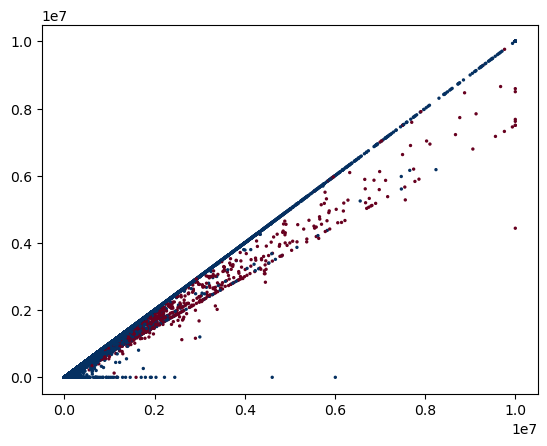

In [115]:
plt.scatter(df_train['CurrentApprovalAmount'], df_train['PAYROLL_PROCEED'], c=pred, s=2, cmap='RdBu')

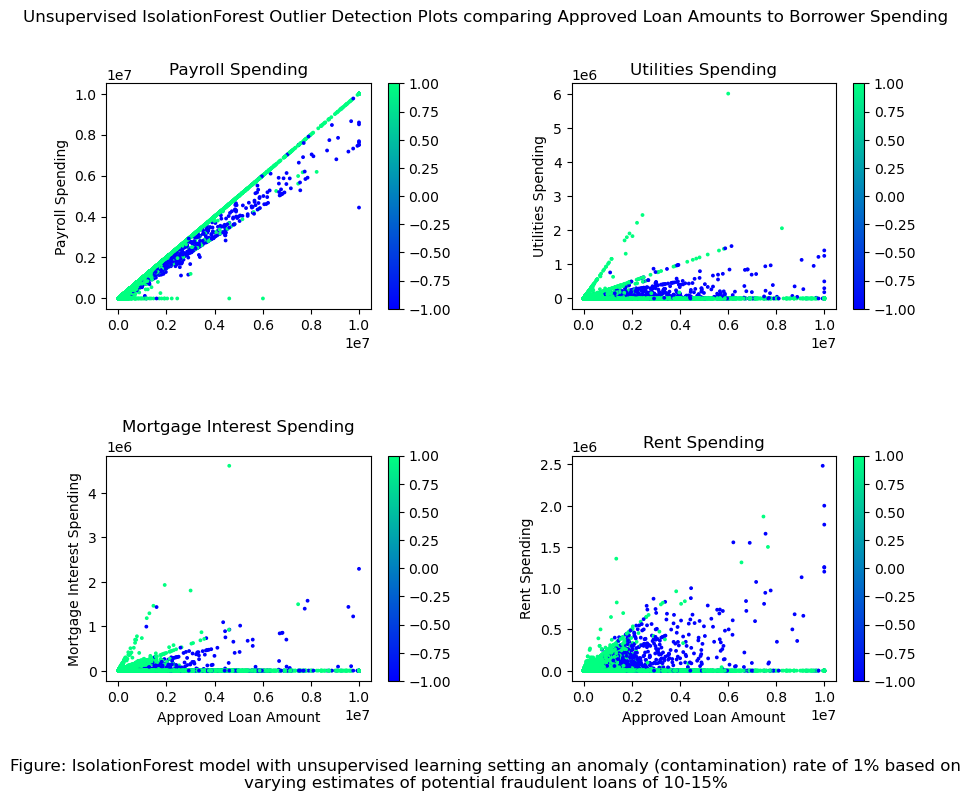

In [116]:
x = df_train['CurrentApprovalAmount']
y1 = df_train['PAYROLL_PROCEED']
y2 = df_train['UTILITIES_PROCEED']
y3 = df_train['MORTGAGE_INTEREST_PROCEED']
y4 = df_train['RENT_PROCEED']

labels = ['PAYROLL_PROCEED', 'UTILITIES_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED']

cmap = 'winter'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,8])
a0 = ax[0, 0].scatter(x, y1, c=pred, s=3, cmap=cmap)
a1 = ax[0, 1].scatter(x, y2, c=pred, s=3, cmap=cmap)
a2 = ax[1, 0].scatter(x, y3, c=pred, s=3, cmap=cmap)
a3 = ax[1, 1].scatter(x, y4, c=pred, s=3, cmap=cmap)

ax[0, 0].set_title('Payroll Spending')
ax[0, 1].set_title('Utilities Spending')
ax[1, 0].set_title('Mortgage Interest Spending')
ax[1, 1].set_title('Rent Spending')

ax[0, 0].set_ylabel('Payroll Spending')
ax[0, 1].set_ylabel('Utilities Spending')
ax[1, 0].set_ylabel('Mortgage Interest Spending')
ax[1, 1].set_ylabel('Rent Spending')

ax[1, 0].set_xlabel('Approved Loan Amount')
ax[1, 1].set_xlabel('Approved Loan Amount')

cbar0 = fig.colorbar(a0, ax=ax[0][0])
cbar1 = fig.colorbar(a1, ax=ax[0][1])
cbar2 = fig.colorbar(a2, ax=ax[1][0])
cbar3 = fig.colorbar(a3, ax=ax[1][1])

fig.tight_layout(pad=5.0)
fig.suptitle('Unsupervised IsolationForest Outlier Detection Plots comparing Approved Loan Amounts to Borrower Spending', wrap=True, horizontalalignment='center')

text = 'Figure: IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 1% based on varying estimates of potential fraudulent loans of 10-15%'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

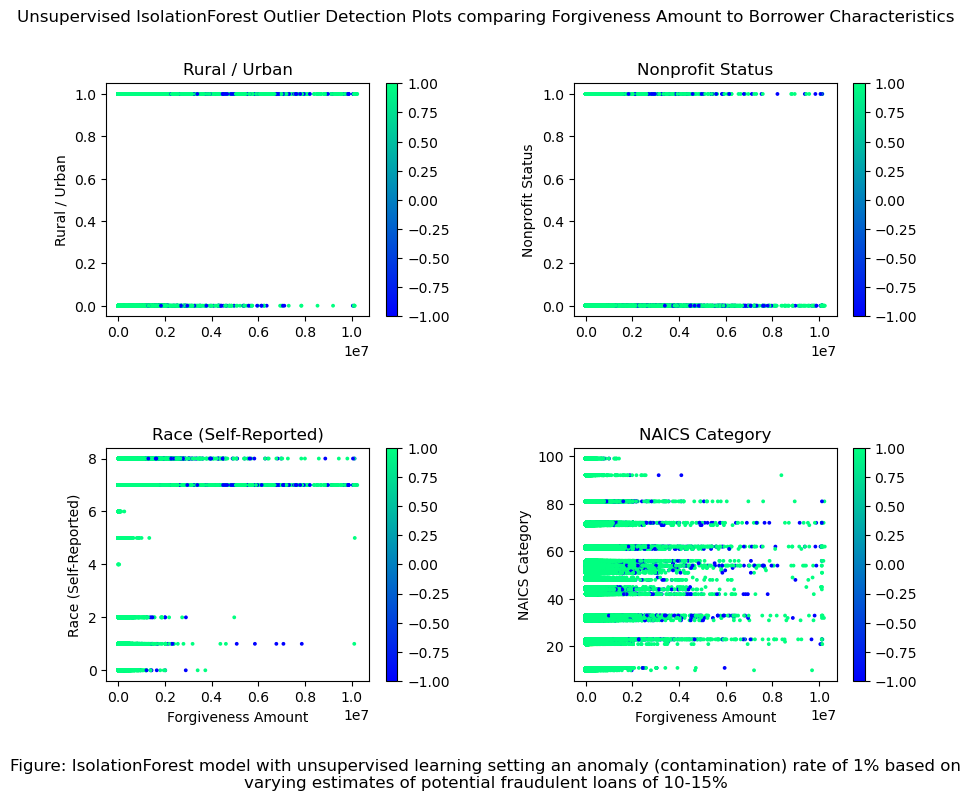

In [117]:
x = df_train['ForgivenessAmount']
y1 = df_train['RuralUrbanIndicator_cat']
y2 = df_train['NonProfit_cat']
y3 = df_train['Race_cat']
y4 = df_train['NAICSCode']

cmap = 'winter'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,8])
a0 = ax[0, 0].scatter(x, y1, c=pred, s=3, cmap=cmap)
a1 = ax[0, 1].scatter(x, y2, c=pred, s=3, cmap=cmap)
a2 = ax[1, 0].scatter(x, y3, c=pred, s=3, cmap=cmap)
a3 = ax[1, 1].scatter(x, y4, c=pred, s=3, cmap=cmap)

ax[0, 0].set_title('Rural / Urban')
ax[0, 1].set_title('Nonprofit Status')
ax[1, 0].set_title('Race (Self-Reported)')
ax[1, 1].set_title('NAICS Category')

ax[0, 0].set_ylabel('Rural / Urban')
ax[0, 1].set_ylabel('Nonprofit Status')
ax[1, 0].set_ylabel('Race (Self-Reported)')
ax[1, 1].set_ylabel('NAICS Category')

ax[1, 0].set_xlabel('Forgiveness Amount')
ax[1, 1].set_xlabel('Forgiveness Amount')

cbar0 = fig.colorbar(a0, ax=ax[0][0])
cbar1 = fig.colorbar(a1, ax=ax[0][1])
cbar2 = fig.colorbar(a2, ax=ax[1][0])
cbar3 = fig.colorbar(a3, ax=ax[1][1])

fig.tight_layout(pad=5.0)
fig.suptitle('Unsupervised IsolationForest Outlier Detection Plots comparing Forgiveness Amount to Borrower Characteristics', wrap=True, horizontalalignment='center')

text = 'Figure: IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 1% based on varying estimates of potential fraudulent loans of 10-15%'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()